# **Step 1:** Clone your TensorFlow 2 object detection API folder to your colab

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2799, done.
remote: Counting objects: 100% (2799/2799), done.
remote: Compressing objects: 100% (2331/2331), done.
remote: Total 2799 (delta 719), reused 1319 (delta 433), pack-reused 0
Receiving objects: 100% (2799/2799), 32.78 MiB | 10.20 MiB/s, done.
Resolving deltas: 100% (719/719), done.


# **Step 2:** Install TensorFlow 2 object detection API into colab

In [ ]:
# Install the Object Detection API
%%bash
cd /content/models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1658497 sha256=29382bb9d87277a97d3c6b6e27674d03ecd727ee3414f79c9aa4ddac647bdc5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-pf9wg9em/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=5e770108495363da7962c97d319f44b4014c3ee2043ed7f125b6a8e50ec81cd7
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=c5fa55dedb9a55185e844805137ad7b89a52a66257772d75c78deec1b89260e2
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78545 sha256=d00d178e9022f239269b9f3c6d974acdf09b952c65e384107ca7

ERROR: multiprocess 0.70.12.2 has requirement dill>=0.3.4, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.26.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.31.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


# **Step 3:** Import TensorFlow 2 libraries into colab

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
tf.config.list_physical_devices('GPU')

# **Step 4:** Run TensorFlow 2 API test

In [ ]:
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

2021-07-15 12:09:14.583802: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-07-15 12:09:16.894984: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-15 12:09:16.957858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-15 12:09:16.958659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-07-15 12:09:16.958707: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successf

# **Step 5:** Prepare custom set of images for training

In [ ]:
%cd /content
%mkdir fine_tuned_model
%mkdir test
%mkdir train
%mkdir training
! ls

/content
fine_tuned_model  models  sample_data  test  train  training


In [ ]:
#Downloading data Training set made by Roboflow
%cd /content

# #Download Training set from git by cloning rep:
# import os
# import pathlib
# # Clone the training set repository if it doesn't already exist
# if "RetrainModelExample" in pathlib.Path.cwd().parts:
#   while "RetrainModelExample" in pathlib.Path.cwd().parts:
#     os.chdir('..')
# elif not pathlib.Path('RetrainModelExample').exists():
#   !git clone --depth 1 https://github.com/KostaMalsev/RetrainModelExample
#   %cd /content/RetrainModelExample/TrainingSet/Picka 
#   !unzip Pickachu.v1.tfrecord.zip -d /content/

#NOTE: Update these TFRecord names to your files containing training set!
#Also, Update relevant rows:in training config file "ssd_mobilenet_v2_320x320_coco17_tpu-8.config"
#label_map_path,input_path 

test_record_fname = '/content/test/price-tags.tfrecord'
train_record_fname = '/content/train/price-tags.tfrecord'
label_map_pbtxt_fname = '/content/train/price-tags_label_map.pbtxt'

/content


# **Step 6:** Set configuration parameters

In [ ]:
#You can change chosen model to deploy different models available in the TF2 object detection zoo

MODELS_CONFIG = {
    'ssd_mobilenet_v2_320x320_coco17': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
        'batch_size': 16
    }
}

chosen_model = 'ssd_mobilenet_v2_320x320_coco17'
num_steps = 1800 #40000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 #Perform evaluation after so many steps
model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your trainin#g

# **Step 7:** Load trained model weights from TensorFlow site

In [ ]:
#Download pretrained weights
%mkdir /content/deploy/
%cd /content/deploy/

import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()
#Shorten the folder name,because long file paths are not yet supported :(
os.rename('ssd_mobilenet_v2_320x320_coco17_tpu-8','mobilnetv2')

#Download training configuration file for mobilenetV2. 
#note: configuration file contain references to your trainig set of images,
#you can change it for your dataset.
%cd /content/deploy
download_config = 'https://raw.githubusercontent.com/KostaMalsev/RetrainModelExample/main/ssd_mobilenet_v2_320x320_coco17_tpu-8.config'
!wget {download_config}

#Prepare frozen model for retraining
fine_tune_checkpoint = '/content/deploy/mobilnetv2/checkpoint/ckpt-0'
pipeline_file = '/content/deploy/ssd_mobilenet_v2_320x320_coco17_tpu-8.config'
model_dir = '/content/training/'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)

/content/deploy
--2021-07-15 12:12:37--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.71.128, 2a00:1450:400c:c02::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.71.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46042990 (44M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_32 100%[===================>]  43.91M  75.1MB/s    in 0.6s    

2021-07-15 12:12:38 (75.1 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’ saved [46042990/46042990]

/content/deploy
--2021-07-15 12:12:39--  https://raw.githubusercontent.com/KostaMalsev/RetrainModelExample/main/ssd_mobilenet_v2_320x320_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercont

# **Step 8:** Run the training process

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

2021-07-15 12:18:17.947299: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-15 12:18:20.498517: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-15 12:18:20.519487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-15 12:18:20.520298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-07-15 12:18:20.520347: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-15 12:18:20.523170: I tensorflow/stream_executor/platform/defa

# **Step 9:** Save retrained model

In [ ]:
#run conversion script to save the retrained model:
#Saved model will be in saved_model.pb file:

import re
import numpy as np

output_directory = '/content/fine_tuned_model'

#place the model weights you would like to export here
last_model_path = '/content/training/'
print(last_model_path)

!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

/content/training/
2021-07-15 12:33:56.809340: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-15 12:33:59.141204: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-15 12:33:59.165060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-15 12:33:59.165929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-07-15 12:33:59.165981: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-15 12:33:59.168882: I tensorflow/stream_exe

# **Testing**

## **Step A** Import images to test folder

In [ ]:
#Import your test images to colab. 
#I use Pinterest to store the the images.

# %mkdir /content/test/

# %cd /content/test/

!curl -L "https://i.pinimg.com/564x/f5/46/c4/f546c47505e1f5f8d17f8458d641b262.jpg" > test.jpeg;

mkdir: cannot create directory ‘/content/test/’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 66488  100 66488    0     0   252k      0 --:--:-- --:--:-- --:--:--  252k


## **Step B** Import visualization libraries

In [ ]:
import os 
import glob
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

## **Step C** Import retrained model

In [ ]:
#Recover our saved model with the latest checkpoint:
pipeline_config = pipeline_file

#Put the last ckpt from training in here, don't use long pathnames:
model_dir = '/content/training/ckpt-2'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore last checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
#ckpt.restore(os.path.join(model_dir))
ckpt.restore(model_dir)

#Function perform detection of the object on image in tensor format: 
def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""
    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn
  
#Define function which performs detection: 
detect_fn = get_model_detection_function(detection_model)


#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

## **Step D** Perform object detection on test image

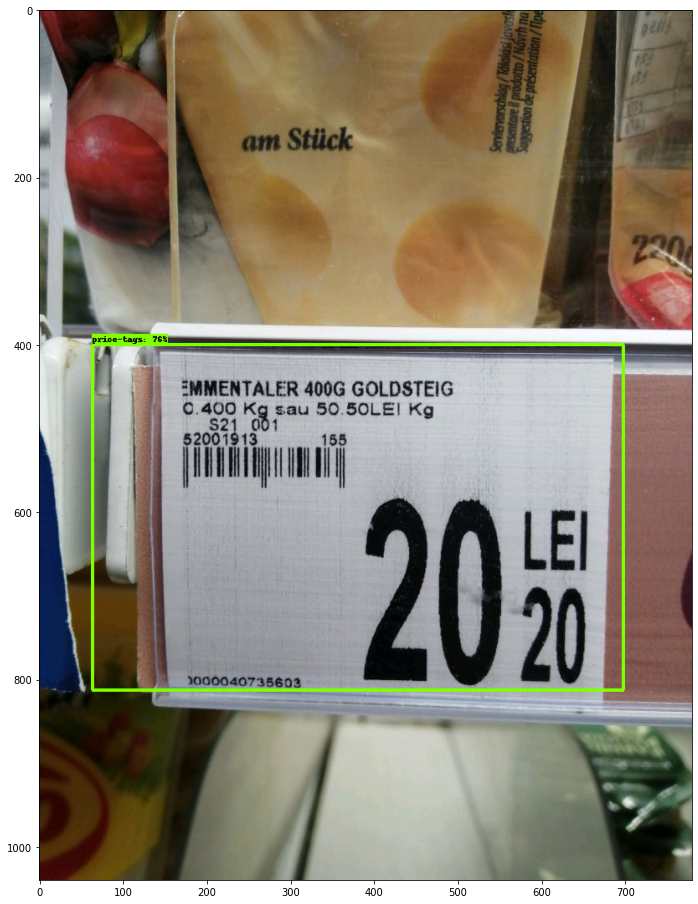

In [ ]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

#Define utility functions for presenting the results:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.
  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.
  Args:
    path: the file path to the image
  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


#Place your test images here:
image_path = '/content/test/Romania_foto_657.jpg'

#Store test images in nmpy array:
image_np = load_image_into_numpy_array(image_path)

#Convert images to tensor form:
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)

#Perform detection on the image in tensor format:
detections, predictions_dict, shapes = detect_fn(input_tensor)

#Visualize the detection boxes on the image:
label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.5,#0.5,#0.5
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

# **Summary**

- Here we retrain the MobileNetV2 with object detection API library and training images of of our choosing.
- The retrained model was exported to frozen format .pb file also known as “SavedModel” format.
- We tested our new retrained object detection model on test images. Training and test images were converted to TFRecord format using Roboflow platform.

# **Download model weights and checkpoints**

In [ ]:
%cd ..

/


In [ ]:
from google.colab import files
files.download('fine_tuned_model') 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!getwd()

/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
!ls

bin	 datalab  home	 lib64	opt   run   sys		       tools
boot	 dev	  lib	 media	proc  sbin  tensorflow-1.15.2  usr
content  etc	  lib32  mnt	root  srv   tmp		       var


In [ ]:
%cp -a /content/gdrive/MyDrive/models/fine_tuned_model /content